In [1]:
!pip install "numpy<1.24" --user

import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 17.1 MB/s eta 0:00:0000:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import geopandas as gpd

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 40)

In [4]:
# Collecte des données

data = pd.read_csv("Donnees-sur-le-parc-de-vehicule-au-niveau-regional.2023-05.csv", sep=';',header=[1])
zones = gpd.read_file('aires.geojson')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [5]:
possibles = []

for i in ["Crit'Air 2", "Crit'Air 3", "Crit'Air 4", "Crit'Air 5"] :
    possibles.append(("Diesel", i))
for i in ["Crit'Air 1", "Crit'Air 2", "Crit'Air 3"] :
    possibles.append(("Essence", i))
    
possibles.append(("Hybride rechargeable", "Crit'Air 1"))
possibles.append(('Electrique et hydrogène', "Crit'Air E"))

In [6]:
# Parc historique

# On se focalise sur les véhicules particuliers et les camionnettes
df1 = data.loc[(data["CATEGORIE_VEHICULE"] == "Véhicule particulier")]

def age_num(age) :
    res = []
    for i in range (len(age)) :
        res.append(int(str(age[i])[0:2]))
    return res

# On créé une colonne avec l'âge du véhicule sous forme numérique
df1.insert(loc = 1, column = 'AGE_NUM', value = age_num(np.array(df1['AGE'], dtype = str)))

# On peut se séparer de certaines colonnes
df1 = df1.drop(['CATEGORIE_VEHICULE', 'REGION_CODE', 'REGION_LIBELLE', 'CLASSE_VEHICULE', 'STATUT_UTILISATEUR', 'AGE'], axis = 1)

# On effectue la somme pour les différentes régions et statuts d'utilisateurs
df1 = df1.groupby(['CARBURANT','CRITAIR', 'AGE_NUM'], as_index = False).sum()
df1 = df1.sort_values(by = ['CARBURANT','CRITAIR', 'AGE_NUM'])

In [7]:
# Il faut rajouter les lignes pour les âges de véhicule qui n'existent pas encore

for p in possibles :
    ages = pd.unique(df1.loc[(df1['CARBURANT'] == p[0]) &
                             (df1['CRITAIR'] == p[1])]
                            ['AGE_NUM']
                        )
    for j in range (0, 26) :
        if j not in ages :
            res = [p[0], p[1], j]
            res.extend(np.zeros(12, dtype = int))
            res = pd.DataFrame([res], columns = df1.columns)
            df1 = pd.concat([df1, res], ignore_index = True)

df1 = df1.sort_values(by = ['CARBURANT','CRITAIR', 'AGE_NUM'])
df1 = df1[df1[['CARBURANT', 'CRITAIR']].apply(tuple, axis=1).isin(possibles)]
df1 = df1.reset_index()
df1 = df1.drop(['index'], axis = 1)

In [8]:
df1.head(5)

,CARBURANT,CRITAIR,AGE_NUM,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,Diesel,Crit'Air 2,0,613931,1523925,1386877,1216452,1169300,1112126,1059557,993562,846449,759822,527529,366422
1,Diesel,Crit'Air 2,1,202067,635256,1596408,1464999,1286269,1214764,1145725,1086359,1020107,881997,796788,560355
2,Diesel,Crit'Air 2,2,11260,206200,647651,1628838,1491741,1299481,1228160,1156419,1112068,1060189,900584,819287
3,Diesel,Crit'Air 2,3,4,11623,204669,640177,1606051,1468861,1277658,1194521,1133315,1099322,1047653,890754
4,Diesel,Crit'Air 2,4,2,1,12184,196210,612145,1535359,1400228,1209525,1128641,1081761,1046898,982306


In [10]:
fit_pannes = pd.read_csv('fit_pannes.csv')

def f(carb, crit, age) :
    res = fit_pannes.loc[(fit_pannes['CARBURANT'] == carb) &
                         (fit_pannes['CRITAIR'] == crit)][str(age)]
    return res.sum()

In [11]:
# Fonction de pannes
# f(car, critair, age_num) donne proportion de pannes moyennes

def panne_inter(row) :
    return int(np.random.binomial(row[-1], f(row['CARBURANT'], row['CRITAIR'], row['AGE_NUM'])))

def panne(df : pd.DataFrame) :
    df_cop = df.copy()
    df_cop['Pannes'] = df_cop.apply(panne_inter, axis = 1)
    return df_cop

# Ca marche!


In [12]:
# Nombre de véhicules neufs à rajouter, à utiliser après pannes

def nbr_vhl_neufs_fonc(df : pd.DataFrame, r) :
    col = df.columns.to_list()
    res = 0
    if not (df[col[-1]] == 0).all() :
        res = df[col[-1]].sum() 
    res += r*df[col[-2]].sum()
    return int(res)

#print(nbr_vhl_neufs_fonc(df, 0.05))

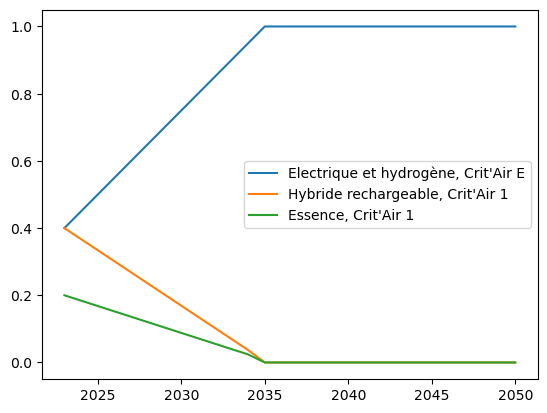

In [13]:
# Distribution des véhicules neufs

def g(carb, crit, age_num, annee) :
    if age_num != 0 :
        return 0
    if annee < 2035 :
        if crit == "Crit'Air E" and carb == "Electrique et hydrogène" :
            return 0.4 + (annee - 2023)*0.05
        if crit == "Crit'Air 1" and carb == "Hybride rechargeable" :
            return 0.4 - (annee - 2023)*0.033
        if crit == "Crit'Air 1" and carb == "Essence" :
            return 0.2 - (annee - 2023)*0.016
        else : return 0
    else :
        if crit == "Crit'Air E" and carb == "Electrique et hydrogène" :
            return 1
        else : return 0

x = np.arange(2023, 2051, 1)
y = [[],[],[]]

for i in range (len(x)) :
    y[0].append(g("Electrique et hydrogène", "Crit'Air E", 0, x[i]))
    y[1].append(g("Hybride rechargeable", "Crit'Air 1", 0, x[i]))
    y[2].append(g("Essence", "Crit'Air 1", 0, x[i]))

plt.plot(x, y[0], label = "Electrique et hydrogène, Crit'Air E")
plt.plot(x, y[1], label = "Hybride rechargeable, Crit'Air 1")
plt.plot(x, y[2], label = "Essence, Crit'Air 1")

plt.legend(loc="center right")
plt.show()

In [14]:
def approx_binomial(n, p) :
    return np.random.normal(n*p, np.sqrt(n*p*(1-p)))

def neufs_inter(row, nbr_vhl_neufs, annee) :
    return (approx_binomial(nbr_vhl_neufs, g(row['CARBURANT'],
                                             row['CRITAIR'], row['AGE_NUM'], annee)))

def vhl_neufs(df : pd.DataFrame, n, a) :
    df_cop = df.copy()
    df_cop['Neufs'] = df_cop.apply(neufs_inter, nbr_vhl_neufs = n, annee = a, axis = 1)
    return df_cop

# g est la fonction qui donne les proportions de tel ou tel type de véhicule dans les véhicules neufs
# Elle renvoie 0 pour les lignes où l'âge du véhicule est supérieur à 0
        

In [15]:
def final(df_arg : pd.DataFrame, annee) :
    df = df_arg.copy()
    # Dans un premier temps, on remet les +25 qui sont pas en pannes
    df['25_plus'] = pd.DataFrame(np.transpose(np.zeros(len(df))))
    idx = df.loc[df['AGE_NUM'] == 25].index
    df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]

    # Ensuite, on fait shifter toutes les colonnes qui ne sont pas +25, en sommant sur la colonne créée au-dessus
    df[str(annee)] = pd.DataFrame(np.transpose(np.zeros(len(df))))
    idx_2 = df.loc[df['AGE_NUM'] != 25].index
    idx_3 = df.loc[df['AGE_NUM'] != 0].index
    df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
    df[str(annee)][idx] = df['25_plus'][idx] + df[df.columns.to_list()[-5]].shift(periods = 1, axis = 0)[idx]

    # Ne pas oublier de rajouter les neufs
    df[str(annee)] += df['Neufs']

    return df

df2 = panne(df1)
df2 = vhl_neufs(df2, nbr_vhl_neufs_fonc(df2, 0.005), 2023)
df2 = final(df2, 2023)
df2.head(5)


/tmp/ipykernel_255/497485533.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return int(np.random.binomial(row[-1], f(row['CARBURANT'], row['CRITAIR'], row['AGE_NUM'])))
/tmp/ipykernel_255/2146189091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
/tmp/ipykernel_255/2146189091.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] +=

,CARBURANT,CRITAIR,AGE_NUM,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022,Pannes,Neufs,25_plus,2023
0,Diesel,Crit'Air 2,0,613931,1523925,1386877,1216452,1169300,1112126,1059557,993562,846449,759822,527529,366422,0,0.0,0.0,0.0
1,Diesel,Crit'Air 2,1,202067,635256,1596408,1464999,1286269,1214764,1145725,1086359,1020107,881997,796788,560355,0,0.0,0.0,366422.0
2,Diesel,Crit'Air 2,2,11260,206200,647651,1628838,1491741,1299481,1228160,1156419,1112068,1060189,900584,819287,0,0.0,0.0,560355.0
3,Diesel,Crit'Air 2,3,4,11623,204669,640177,1606051,1468861,1277658,1194521,1133315,1099322,1047653,890754,0,0.0,0.0,819287.0
4,Diesel,Crit'Air 2,4,2,1,12184,196210,612145,1535359,1400228,1209525,1128641,1081761,1046898,982306,0,0.0,0.0,890754.0


In [16]:
# Ne pas oublier de drop les colonnes 'Pannes', 'Neufs' et '25_plus'

In [17]:
df1.head(5)

,CARBURANT,CRITAIR,AGE_NUM,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,Diesel,Crit'Air 2,0,613931,1523925,1386877,1216452,1169300,1112126,1059557,993562,846449,759822,527529,366422
1,Diesel,Crit'Air 2,1,202067,635256,1596408,1464999,1286269,1214764,1145725,1086359,1020107,881997,796788,560355
2,Diesel,Crit'Air 2,2,11260,206200,647651,1628838,1491741,1299481,1228160,1156419,1112068,1060189,900584,819287
3,Diesel,Crit'Air 2,3,4,11623,204669,640177,1606051,1468861,1277658,1194521,1133315,1099322,1047653,890754
4,Diesel,Crit'Air 2,4,2,1,12184,196210,612145,1535359,1400228,1209525,1128641,1081761,1046898,982306


In [18]:
df_mod = df1.copy()

for a in range(2023, 2051) :
    df_mod = panne(df_mod)
    df_mod = vhl_neufs(df_mod, nbr_vhl_neufs_fonc(df_mod, 0.05), a)
    df_mod = final(df_mod, a)
    df_mod = df_mod.drop(['Pannes', 'Neufs', '25_plus'], axis = 1)

df_mod.head(5)

/tmp/ipykernel_255/497485533.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return int(np.random.binomial(row[-1], f(row['CARBURANT'], row['CRITAIR'], row['AGE_NUM'])))
/tmp/ipykernel_255/2146189091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
/tmp/ipykernel_255/2146189091.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] +=

,CARBURANT,CRITAIR,AGE_NUM,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022,2023,2024,2025,2026,2027,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,Diesel,Crit'Air 2,0,613931,1523925,1386877,1216452,1169300,1112126,1059557,993562,846449,759822,527529,366422,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Diesel,Crit'Air 2,1,202067,635256,1596408,1464999,1286269,1214764,1145725,1086359,1020107,881997,796788,560355,366422.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Diesel,Crit'Air 2,2,11260,206200,647651,1628838,1491741,1299481,1228160,1156419,1112068,1060189,900584,819287,560355.0,366422.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Diesel,Crit'Air 2,3,4,11623,204669,640177,1606051,1468861,1277658,1194521,1133315,1099322,1047653,890754,819287.0,560355.0,366422.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Diesel,Crit'Air 2,4,2,1,12184,196210,612145,1535359,1400228,1209525,1128641,1081761,1046898,982306,890754.0,819287.0,560355.0,366422.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_y = df_mod.drop(['AGE_NUM'], axis = 1)
df_y = df_y.groupby(['CARBURANT', 'CRITAIR'], as_index = False).sum()
df_y.head(10)

,CARBURANT,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022,2023,2024,2025,2026,2027,2028,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,Diesel,Crit'Air 2,827265,2377008,3847792,5159016,6373024,7446200,8448397,9334636,10092595,10834684,11296179,11518003,1.148766e+07,1.138260e+07,1.114225e+07,1.072914e+07,1.013378e+07,9.369001e+06,...,6.440003e+06,5.392221e+06,4.370420e+06,3.414043e+06,2.555975e+06,1.824781e+06,1.239466e+06,7.959190e+05,4.792300e+05,2.698770e+05,1.416070e+05,6.870000e+04,3.089100e+04,1.302300e+04,5.448000e+03,2.326000e+03,1.066000e+03,2.660000e+02,7.300000e+01,2.200000e+01
1,Diesel,Crit'Air 3,7742704,7760899,7661174,7578691,7508905,7436490,7308735,7124372,6860385,6607215,6312533,5979327,5.346663e+06,4.607515e+06,3.822567e+06,3.047245e+06,2.332272e+06,1.709125e+06,...,5.159270e+05,3.262210e+05,2.015130e+05,1.235800e+05,7.587900e+04,4.605600e+04,2.236600e+04,1.062400e+04,5.009000e+03,2.399000e+03,1.136000e+03,5.740000e+02,2.870000e+02,1.360000e+02,6.200000e+01,2.600000e+01,1.400000e+01,6.000000e+00,3.000000e+00,2.000000e+00
2,Diesel,Crit'Air 4,5846552,5728183,5612884,5476665,5331907,5141115,4897300,4591724,4166627,3669834,3231905,2862703,2.185917e+06,1.606369e+06,1.135307e+06,7.734420e+05,5.285070e+05,3.528920e+05,...,9.775500e+04,5.355300e+04,2.878700e+04,1.535000e+04,8.203000e+03,4.459000e+03,2.285000e+03,1.221000e+03,6.480000e+02,3.480000e+02,1.900000e+02,8.700000e+01,3.800000e+01,2.000000e+01,1.400000e+01,6.000000e+00,6.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
3,Diesel,Crit'Air 5,2353317,2257289,2145065,2016424,1880408,1729314,1562729,1390436,1184213,959625,771784,653626,5.675830e+05,4.953490e+05,4.380800e+05,3.894250e+05,3.267940e+05,2.729720e+05,...,1.590020e+05,1.324090e+05,1.106560e+05,9.231400e+04,7.704200e+04,6.425400e+04,5.357100e+04,4.468700e+04,3.735400e+04,3.119100e+04,2.604900e+04,2.174100e+04,1.816300e+04,1.513900e+04,1.261200e+04,1.055400e+04,8.770000e+03,7.326000e+03,6.095000e+03,5.094000e+03
4,Electrique et hydrogène,Crit'Air E,1256,3725,8771,16484,25320,41329,60908,82227,106439,141498,245281,403010,1.936595e+06,3.776273e+06,5.943471e+06,8.454204e+06,1.132045e+07,1.455455e+07,...,2.650231e+07,3.115988e+07,3.606894e+07,4.122630e+07,4.673448e+07,5.240990e+07,5.830532e+07,6.442811e+07,7.075442e+07,7.723031e+07,8.380470e+07,9.043600e+07,9.710397e+07,1.038062e+08,1.105369e+08,1.172918e+08,1.240888e+08,1.309838e+08,1.380068e+08,1.452171e+08
5,Essence,Crit'Air 1,336021,910749,1409943,1960319,2565414,3313130,4213367,5255558,6508307,7853625,8746597,9487099,1.008149e+07,1.058865e+07,1.100064e+07,1.130496e+07,1.147896e+07,1.149583e+07,...,1.039207e+07,9.707981e+06,8.967838e+06,8.172072e+06,7.277060e+06,6.421138e+06,5.605730e+06,4.833191e+06,4.106446e+06,3.425727e+06,2.795932e+06,2.224137e+06,1.716727e+06,1.276853e+06,9.105080e+05,6.312000e+05,4.237990e+05,2.754780e+05,1.732400e+05,1.052310e+05
6,Essence,Crit'Air 2,2952779,2929628,2893449,2856940,2833479,2815089,2782452,2742739,2684999,2639277,2579829,2505199,2.389896e+06,2.246546e+06,2.080551e+06,1.898563e+06,1.706839e+06,1.511631e+06,...,9.645120e+05,8.254320e+05,6.981190e+05,5.830010e+05,4.900850e+05,4.009490e+05,3.156960e+05,2.478700e+05,1.946790e+05,1.527670e+05,1.201840e+05,9.428000e+04,7.405400e+04,5.826900e+04,4.577800e+04,3.582300e+04,2.813000e+04,2.205700e+04,1.722600e+04,1.357200e+04
7,Essence,Crit'Air 3,5400983,5224607,5040386,4850634,4668418,4467292,4235181,3985278,3675165,3327339,2968045,2672601,2.410186e+06,2.164243e+06,1.934954e+06,1.719639e+06,1.517124e+06,1.330927e+06,...,8.784820e+05,7.475170e+05,6.351970e+05,5.400460e+05,4.589130e+05,3.899390e+05,3.314660e+05,2.815150e+05,2.394560e+05,2.037590e+05,1.732890e+05,1.472090e+05,1.254030e+05,1.066590e+05,9.072200e+04,7.704100e+04,6.546600e+04,5.556200e+04,4.731100e+04,4.016500e+04
8,Hybride rechargeable,Crit'Air 1,17579,26333,29545,29834,31325,3632

/tmp/ipykernel_255/2943365645.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x, y, label = str(v[0]) + ", " + str(v[1]))


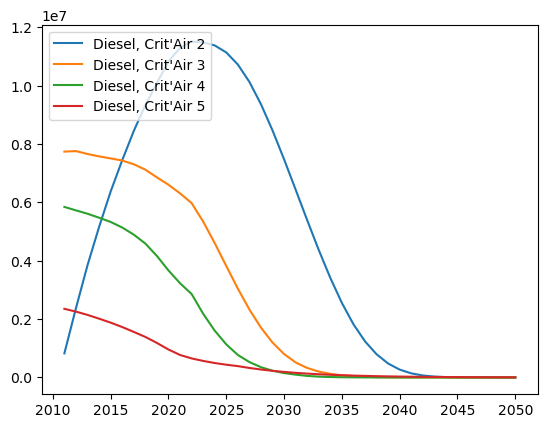

In [20]:
x = np.arange(2011, 2051, 1)

for i in range (0, 4) :
    v = df_y.iloc[i]
    y = np.array(v[2:])
    plt.plot(x, y, label = str(v[0]) + ", " + str(v[1]))

plt.legend(loc = "upper left")
plt.show()


/tmp/ipykernel_255/2900855146.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x, y, label = str(v[0]) + ", " + str(v[1]))


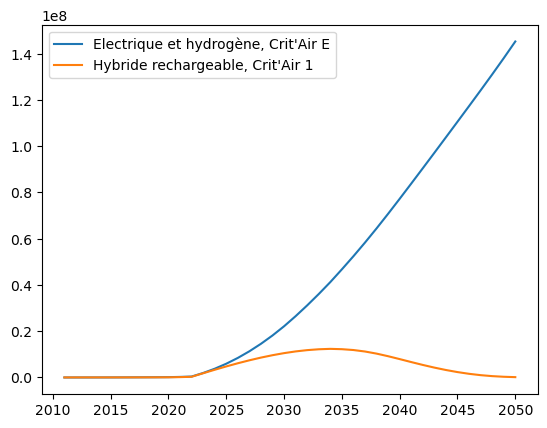

In [21]:
for i in [4, 8] :
    v = df_y.iloc[i]
    y = np.array(v[2:])
    plt.plot(x, y, label = str(v[0]) + ", " + str(v[1]))

plt.legend(loc = "upper left")
plt.show()

/tmp/ipykernel_255/636523947.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x, y, label = str(v[0]) + ", " + str(v[1]))


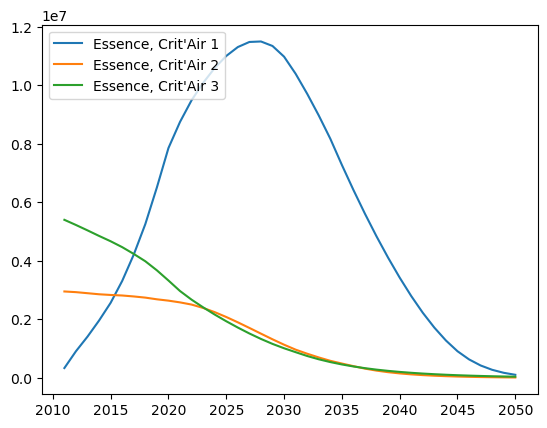

In [22]:
for i in range(5, 8) :
    v = df_y.iloc[i]
    y = np.array(v[2:])
    plt.plot(x, y, label = str(v[0]) + ", " + str(v[1]))

plt.legend(loc = "upper left")
plt.show()

In [23]:
def norme(age, annee) :
    if annee - age < 1997 : return "Euro 1"
    elif annee - age < 2001 : return "Euro 2"
    elif annee - age < 2006 : return "Euro 3"
    elif annee - age < 2011 : return "Euro 4"
    elif annee - age < 2013 : return "Euro 5a"
    elif annee - age < 2015 : return "Euro 5b"
    elif annee - age < 2018 : return "Euro 6b"
    elif annee - age < 2019 : return "Euro 6c"
    elif annee - age < 2021 : return "Euro 6d-TEMP"
    else : return "Euro 6d"

In [24]:
df_mod2 = df_mod.copy()

def enleve_parc(row) :
    s = str(row['Annee'])
    if len(s) > 4 :
        return  int(s[5:])
    return int(s)

def norme_ajout(row) :
    return norme(row["AGE_NUM"], row["Annee"])

df_mod2 = pd.melt(df_mod2, id_vars = ["CARBURANT", "CRITAIR", "AGE_NUM"],
                           var_name = 'Annee')

df_mod2['Annee'] = df_mod2.apply(enleve_parc, axis = 1)
df_mod2['Norme'] = df_mod2.apply(norme_ajout, axis = 1)

df_mod2.head(5)

,CARBURANT,CRITAIR,AGE_NUM,Annee,value,Norme
0,Diesel,Crit'Air 2,0,2011,613931.0,Euro 5a
1,Diesel,Crit'Air 2,1,2011,202067.0,Euro 4
2,Diesel,Crit'Air 2,2,2011,11260.0,Euro 4
3,Diesel,Crit'Air 2,3,2011,4.0,Euro 4
4,Diesel,Crit'Air 2,4,2011,2.0,Euro 4


In [25]:
df_mod2 = df_mod2.drop(['CRITAIR', 'AGE_NUM'], axis = 1)
df_mod2 = df_mod2.groupby(['CARBURANT', 'Annee', 'Norme'], as_index = False).sum()
df_mod2.head(5)

,CARBURANT,Annee,Norme,value
0,Diesel,2011,Euro 1,690.0
1,Diesel,2011,Euro 2,1650922.0
2,Diesel,2011,Euro 3,5574737.0
3,Diesel,2011,Euro 4,7945416.0
4,Diesel,2011,Euro 5a,1598073.0


In [26]:
df_mod2.head(20)

,CARBURANT,Annee,Norme,value
0,Diesel,2011,Euro 1,690.0
1,Diesel,2011,Euro 2,1650922.0
2,Diesel,2011,Euro 3,5574737.0
3,Diesel,2011,Euro 4,7945416.0
4,Diesel,2011,Euro 5a,1598073.0
5,Diesel,2012,Euro 1,702.0
6,Diesel,2012,Euro 2,1575028.0
7,Diesel,2012,Euro 3,5463546.0
8,Diesel,2012,Euro 4,7836480.0
9,Diesel,2012,Euro 5a,3247623.0


In [27]:
df_essence = pd.read_csv('emissions_essence.csv')
df_diesel = pd.read_csv('emissions_diesel.csv')

In [28]:
df_diesel.head(10)

,Norme,Euro 1,Euro 2,Euro 3,Euro 4,Euro 5a,Euro 5b,Euro 6b,Euro 6c,Euro 6d -TEMP,Euro 6d
0,Oxydes d'azote (NOx),-,-,500,250,180,180,80,80,80,80
1,Monoxyde de carbone (CO),2 720,1 000,640,500,500,500,500,500,500,500
2,Hydrocarbures (THC),-,-,-,-,-,-,-,-,-,-
3,Hydrocarbures non méthaniques (HCNM),-,-,-,-,-,-,-,-,-,-
4,HC + NOX,970,700,560,300,230,230,170,170,170,170
5,Particules (PM),140,80,50,25,5,45,45,45,45,45
6,Particules (PN) (nb/km),-,-,-,-,6 × 1011,6 × 1011,6 × 1011,6 × 1011,6 × 1011,6 × 1011


In [29]:
df_essence.head(10)

,Norme,Euro 1,Euro 2,Euro 3,Euro 4,Euro 5[25],Euro 6b[26],Euro 6c,Euro 6d -TEMP,Euro 6d
0,Oxydes d'azote (NOx),-,-,150,80,60,60,60,60,60
1,Monoxyde de carbone (CO),2 720,2 200,2 200,1 000,1 000,1 000,1 000,1 000,1 000
2,Hydrocarbures (HC),-,-,200,100,100,100,100,100,100
3,Hydrocarbures non méthaniques (HCNM),-,-,-,-,68,68,68,68,68
4,HC + NOX,970,500,-,-,-,-,-,-,-
5,Particules (PM),-,-,-,-,5[* 1],5[* 1],45,45,45
6,Particules (PN) (nb/km),-,-,-,-,-,6 × 1012[* 2],6 × 1011,6 × 1011,6 × 1011


In [30]:
df_diesel2 = df_diesel.transpose()
norme = df_diesel2.index.to_list()[1:]
df_diesel2 = pd.DataFrame(np.array(df_diesel2.iloc[1:]), columns = df_diesel2.iloc[0])
df_diesel2['Norme'] = pd.DataFrame(norme)
df_diesel2['CARBURANT'] = pd.DataFrame(['Diesel' for i in range (len(df_diesel2))])

df_essence2 = df_essence.transpose()
norme = df_essence2.index.to_list()[1:]
df_essence2 = pd.DataFrame(np.array(df_essence2.iloc[1:]), columns = df_essence2.iloc[0])
df_essence2['Norme'] = pd.DataFrame(norme)
df_essence2['CARBURANT'] = pd.DataFrame(['Essence' for i in range (len(df_essence2))])

df_emissions = pd.concat([df_diesel2, df_essence2], ignore_index=True)
df_emissions = df_emissions.drop(['Particules (PN) (nb/km)', 'Particules (PM)'], axis = 1)

df_emissions.head(20)

Norme,Oxydes d'azote (NOx),Monoxyde de carbone (CO),Hydrocarbures (THC),Hydrocarbures non méthaniques (HCNM),HC + NOX,Norme,CARBURANT,Hydrocarbures (HC)
0,-,2 720,-,-,970,Euro 1,Diesel,NaN
1,-,1 000,-,-,700,Euro 2,Diesel,NaN
2,500,640,-,-,560,Euro 3,Diesel,NaN
3,250,500,-,-,300,Euro 4,Diesel,NaN
4,180,500,-,-,230,Euro 5a,Diesel,NaN
5,180,500,-,-,230,Euro 5b,Diesel,NaN
6,80,500,-,-,170,Euro 6b,Diesel,NaN
7,80,500,-,-,170,Euro 6c,Diesel,NaN
8,80,500,-,-,170,Euro 6d -TEMP,Diesel,NaN
9,80,500,-,-,170,Euro 6d,Diesel,NaN


In [31]:
df_mod3 = df_mod2.join(df_emissions.set_index(['Norme', 'CARBURANT']), on = ['Norme', 'CARBURANT'])
col = df_mod3.columns.to_list()[4:]

def calcul_emissions (row) :
    for c in col :
        if row[c] != '-' :
            x = str(row[c]).replace("\xa0", "")
            if x != "nan" :
                row[c] = int(x)*row['value']
    return row

df_mod3 = df_mod3.apply(calcul_emissions, axis = 1)
df_mod3.head(5)

,CARBURANT,Annee,Norme,value,Oxydes d'azote (NOx),Monoxyde de carbone (CO),Hydrocarbures (THC),Hydrocarbures non méthaniques (HCNM),HC + NOX,Hydrocarbures (HC)
0,Diesel,2011,Euro 1,690.0,-,1.876800e+06,-,-,669300.0,NaN
1,Diesel,2011,Euro 2,1650922.0,-,1.650922e+09,-,-,1155645400.0,NaN
2,Diesel,2011,Euro 3,5574737.0,2787368500.0,3.567832e+09,-,-,3121852720.0,NaN
3,Diesel,2011,Euro 4,7945416.0,1986354000.0,3.972708e+09,-,-,2383624800.0,NaN
4,Diesel,2011,Euro 5a,1598073.0,287653140.0,7.990365e+08,-,-,367556790.0,NaN


In [32]:
df_mod4 = df_mod3.drop(['CARBURANT', 'Norme', 'value'], axis = 1)
df_mod4 = df_mod4.replace(to_replace = "-", value = 0)
df_mod4 = df_mod4.replace(to_replace = "nan", value = 0)
df_mod4 = df_mod4.groupby(['Annee'], as_index = False).sum()

df_mod4.head(5)

,Annee,Oxydes d'azote (NOx),Monoxyde de carbone (CO),Hydrocarbures (THC),Hydrocarbures non méthaniques (HCNM),HC + NOX,Hydrocarbures (HC)
0,2011,5.781434e+09,2.447512e+10,0.0,0.0,8.031528e+09,941364000.0
1,2012,5.981728e+09,2.469034e+10,0.0,0.0,8.214322e+09,923271800.0
2,2013,6.138259e+09,2.476282e+10,0.0,0.0,8.334324e+09,903526900.0
3,2014,6.261937e+09,2.471909e+10,0.0,0.0,8.398682e+09,883606400.0
4,2015,6.252401e+09,2.466469e+10,0.0,0.0,8.371468e+09,866374500.0


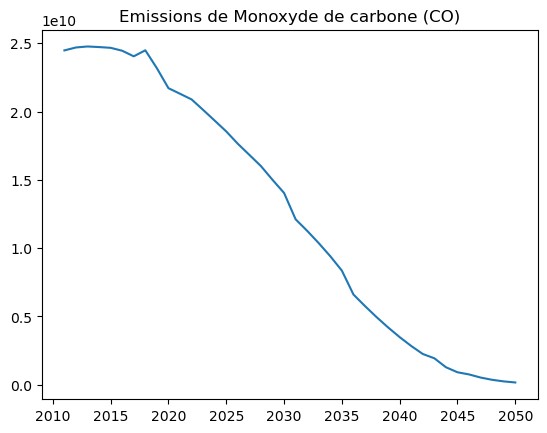

In [33]:
plt.plot(np.array(df_mod4['Annee'], dtype = int), np.array(df_mod4['Monoxyde de carbone (CO)'], dtype = float))
plt.title("Emissions de Monoxyde de carbone (CO)")
plt.show()

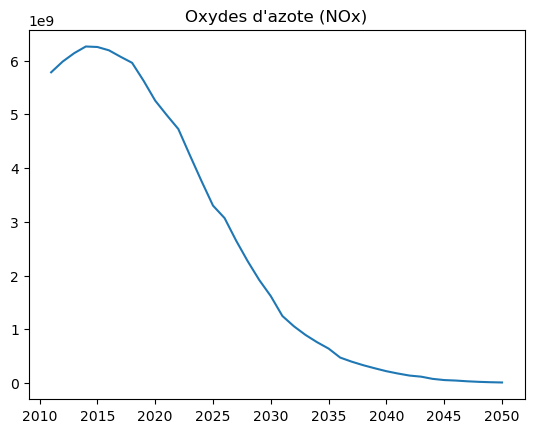

In [34]:
plt.plot(np.array(df_mod4['Annee'], dtype = int), np.array(df_mod4["Oxydes d'azote (NOx)"], dtype = float))
plt.title("Oxydes d'azote (NOx)")
plt.show()